In [177]:
from scipy.io import loadmat, savemat
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import signal
import cmath
import numpy as np
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

### Example Data

https://github.com/mullerlab/generalized-phase

In [69]:
data = loadmat(Path.home() / 'Desktop' / 'x.mat')['x']

In [70]:
data.shape

(681, 1)

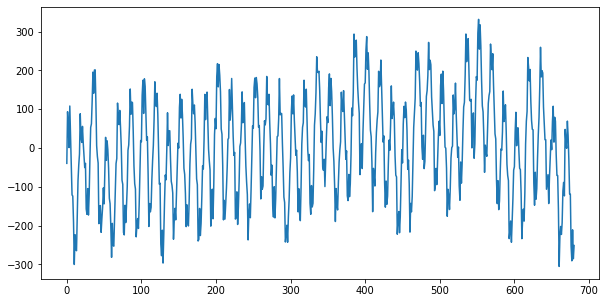

In [71]:
plt.figure(figsize=(10,5))
plt.plot(data)

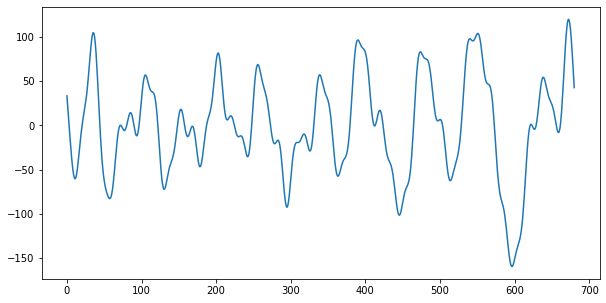

In [72]:
nyquist = 0.5 * 1200
low = 5 / nyquist
high = 50 / nyquist
order = 3

b, a = signal.butter(order, [low, high], btype='band')

# Apply the filter to the signal using filtfilt for zero-phase filtering
filtered_data = signal.filtfilt(b, a, data[:,0])

plt.figure(figsize=(10,5))
plt.plot(filtered_data)

In [73]:
# generalized phase, computed in MATLAB
gp_data = loadmat(Path.home() / 'Desktop' / 'xgp.mat')['xgp']

In [101]:
gp_data[0,0]
# complex numbers
# angle = phase

(1.5420742194606685+84.96799315738292j)

In [75]:
gp_data.shape

(681, 1)

In [100]:
z1 = gp_data[0,0]
cmath.phase(z1)* 180 / cmath.pi

88.96025971276168

In [79]:
phase_angles = np.zeros(gp_data.shape)
for i in range(gp_data.shape[0]):
    z = gp_data[i,0]
    # print(z2)
    phase_angles[i,0] = cmath.phase(z) * 180 / cmath.pi

In [80]:
print(phase_angles.max())
print(phase_angles.min())
phase_angles.shape

179.86668755945328
-179.19527672985433


(681, 1)

In [81]:
filtered_data.shape

(681,)

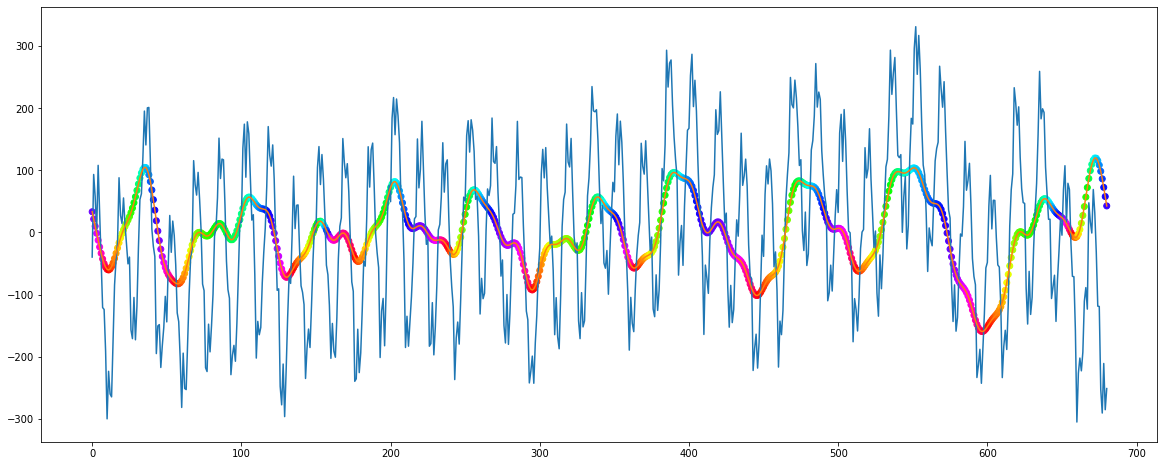

In [103]:
plt.figure(figsize=(20,8))

import matplotlib
cmap = 'hsv'

norm = matplotlib.colors.Normalize(vmin=-180, vmax=180)

c = norm(phase_angles[:,0])

plt.plot(data)
plt.plot(filtered_data)
plt.scatter(np.arange(filtered_data.shape[0]), filtered_data, c=c, cmap='hsv')

### Allen Data

In [107]:
output_dir = Path.home() / 'Desktop' / 'ecephys_data'
cache = EcephysProjectCache.from_warehouse(manifest = output_dir / 'manifest.json')

session_id = 715093703
session = cache.get_session_data(session_id)

VISp_probe_id = 810755801
lfp = session.get_lfp(VISp_probe_id)

In [172]:
# this works for selecting interesting channels and time ranges
lfp.sel(channel=[850261814,850261790]).sel(time=slice(29, 30)).data.shape

(1250, 2)

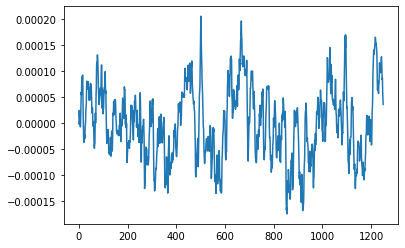

In [178]:
# saving as a mat file
data_to_save = lfp.sel(channel=[850261814]).sel(time=slice(29, 30)).data

plt.plot(data_to_save)
plt.show()

savemat('allen_data.mat', {'x': data_to_save})

In [179]:
gp_data = loadmat(Path.home() / 'Desktop' / 'allen_xgp.mat')['xgp']